In [2]:
import numpy as np

import seaborn
import matplotlib.pyplot as plt

In [3]:
MAP = ['OOOO',
       'OWON',
       'OOOP']

desc = np.array(MAP, dtype='c')
nrow, ncol = desc.shape
nA = 4 # actions number
nS = nrow * ncol # states number
is_slippery = False

R_positive = 10
R_negative = -10
r = -1


In [5]:
def to_s(row, col):
    return row*4 + col


def get_next_state(r, c, action):
    """actions: [0, 1, 2, 3] = [left, down, right, up]"""
    if action == 3:
        r = max(0, r - 1)
    elif action == 1:
        r = min(nrow - 1, r + 1)
    elif action == 0:
        c = max(0, c - 1)
    elif action == 2:
        c = min(ncol - 1, c + 1)
    return r, c


def get_reward(letter, new_letter):
    trans_rewards = {b'OO': r,
                     b'OW': r,
                     b'OP': R_positive,
                     b'ON': R_negative
    }
    return trans_rewards[letter + new_letter]


In [6]:
def get_dynamics(ncol, nrow, nS, nA):
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    for r in range(nrow):
        for c in range(ncol):
            s = to_s(r, c)
            for a in range(nA):
                dynamics = P[s][a]
                letter = desc[r, c]
                if letter in b'PNW': # terminal states
                    # (p, s', reward, is_terminal)
                    dynamics.append((0, s, 0, True))
                else:
                    if is_slippery:
                        # define the perpendicular trajectory actions, with the action
                        for b in [(a - 1) % 4, a, (a + 1) % 4]:
                            new_r, new_c = get_next_state(r, c, b)
                            new_s = to_s(new_r, new_c)
                            new_letter = desc[new_r, new_c]
                            if new_letter == b'W':
                                new_letter = letter
                                new_s = s
                            terminated = new_letter in b'PN'
                            reward = get_reward(letter, new_letter)
                            dynamics.append((1.0/3.0, new_s, reward, terminated)) # there are 2 perpendicular move trajectories, so with the action they add up to 3 probable actions
                    else:
                        new_r, new_c = get_next_state(r, c, a)
                        new_s = to_s(new_r, new_c) 
                        new_letter = desc[new_r, new_c]
                        terminated = new_letter in b'PN'
                        reward = get_reward(letter, new_letter)
                        dynamics.append((1.0, new_s, reward, terminated))
    return P


In [7]:
P = get_dynamics(ncol, nrow, nS, nA)
policy_p = np.ones((nS, nA)) / nA


In [9]:
def policy_iteration(policy, P, gamma=0.75, theta=1e-5):
    delta = np.float32("inf")
    nS = len(P.keys())
    V = np.zeros(nS)

    while theta < delta:
        delta = 0
        
        for s in range(nS):
            Vs = 0
            for action, action_p in enumerate(policy[s]):
                for (p, new_s, reward, terminated) in P[s][action]:
                    Vs += action_p * p * (reward + gamma * V[new_s])
            delta = max(delta, np.abs(V[s] - Vs))
            V[s] = Vs
    return V


In [20]:
V_1 = policy_iteration(policy=policy_p, P=P)

(np.float64(0.0), np.float64(4.0), np.float64(3.0), np.float64(0.0))

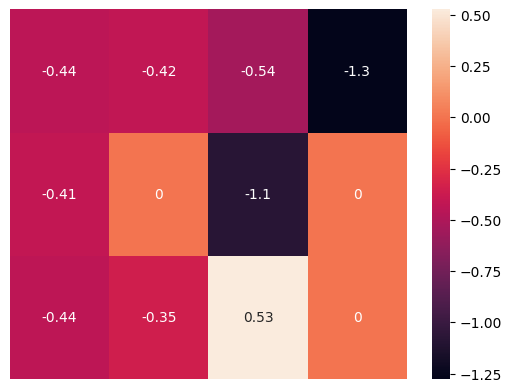

In [21]:
seaborn.heatmap(V_1.reshape(nrow, ncol), annot=True)
plt.axis("off")


In [12]:
from numpy.linalg import solve

In [22]:
def bellman_SLE(policy, P, gamma=0.75):
    nS = len(P.keys())
    A = np.eye(nS)
    b = np.zeros(nS)
    
    for s in range(nS):
        for action, action_p in enumerate(policy[s]):
            for (p, new_s, reward, terminated) in P[s][action]:
                A[s][new_s] -= action_p * p * gamma
                b[s] += action_p * p * reward

    V = solve(A, b)
    return V, A, b


In [23]:
V_2, A, b = bellman_SLE(policy_p, P)

(np.float64(0.0), np.float64(4.0), np.float64(3.0), np.float64(0.0))

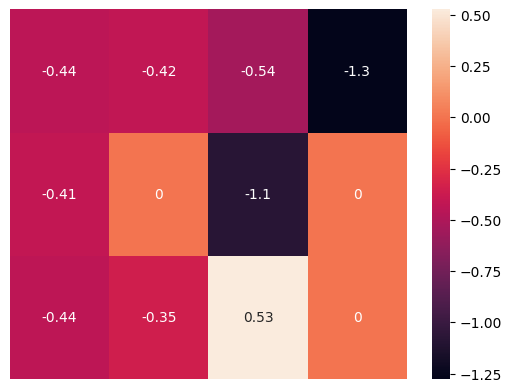

In [24]:
seaborn.heatmap(V_2.reshape(nrow, ncol), annot=True)
plt.axis("off")


# Policy improvement

In [32]:
def q_from_v(P, V, s, gamma=0.75):
    nA = 4
    q = np.zeros(nA)
    for a in range(nA):
        for (p, new_s, reward, terminated) in P[s][a]:
            q[a] += p * (reward + gamma * V[new_s])
    return q
    

In [27]:
q_from_v(P, V_1, 0)

array([-0.48019719, -0.47132017, -0.4736654 , -0.48019719])

In [29]:
def Q_from_v(P, V, gamma=0.75):
    nS = V.shape[0] 
    Q = np.array([q_from_v(P, V, s, gamma=gamma) for s in range(nS)])
    return Q


In [33]:
Q_from_v(P, V_1)

array([[-0.44348123, -0.43682346, -0.43858238, -0.44348123],
       [-0.44348123, -0.33333333, -0.46858832, -0.43858238],
       [-0.43858238, -0.60439133, -0.65251818, -0.46858832],
       [-0.46858832, -3.33333333, -0.65251818, -0.65251818],
       [-0.43682346, -0.44220425, -0.33333333, -0.44348123],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.33333333, -0.20167295, -3.33333333, -0.46858832],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.44220425, -0.44220425, -0.42070292, -0.43682346],
       [-0.44220425, -0.42070292, -0.20167295, -0.33333333],
       [-0.42070292, -0.20167295,  3.33333333, -0.60439133],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [34]:
policy = np.ones((nS, nA)) / nA
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [35]:
s = 0
q = q_from_v(P, V_1, s, gamma=0.75)
q

array([-0.44348123, -0.43682346, -0.43858238, -0.44348123])

In [48]:
policy

array([[0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [55]:
def improve_policy(P, V, policy, gamma=0.75):
    nS = V.shape[0]
    nA = 4
    # policy = np.ones([nS, nA]) / nA

    for s in range(nS):
        q = q_from_v(P, V, s, gamma=gamma)
        best_action = np.argwhere(q == np.max(q)).flatten()
        policy[s] = np.sum([np.eye(nA)[i] for i in best_action], axis=0) / len(best_action)
    return policy


In [56]:
# optimize_policy()

policy = np.ones([nS, nA]) / nA
V_curr = policy_iteration(policy=policy, P=P, gamma=0.75, theta=1e-5)
policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=0.75)
V_next = policy_iteration(policy=policy, P=P, gamma=0.75, theta=1e-5)
theta = 1e-5

i = 0
while np.max(np.abs(V_next - V_curr)) > theta:
    V_curr = V_next
    policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=0.75)
    V_next = policy_iteration(policy=policy, P=P, gamma=0.75, theta=1e-5)
    i += 1

In [57]:
i

2

In [54]:
def optimize_policy(P, nS, nA, gamma=0.75, theta=1e-4):
    policy = np.ones([nS, nA]) / nA
    V_curr = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)
    policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=gamma)
    V_next = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)

    # i = 0
    while np.max(np.abs(V_next - V_curr)) > theta:
        V_curr = V_next
        policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=gamma)
        V_next = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)
        # i += 1
    return V_next, policy